<a href="https://colab.research.google.com/github/mateusribeirocampos/diollm/blob/main/Facial_recognition_using_Keras_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de reconhecimento facial

Importação dos frameworks e bibliotecas


In [58]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
import cv2
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

warnings.filterwarnings('ignore')
%matplotlib inline

ModuleNotFoundError: No module named 'Augmentor'

## Carregar o dataset



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Caminhos
input_base = "/content/drive/MyDrive/Cleaned_Dataset"
output_base = "/content/drive/MyDrive/actors_bbt_split"

# Cria pastas de treino e teste
os.makedirs(os.path.join(output_base, "train"), exist_ok=True)
os.makedirs(os.path.join(output_base, "test"), exist_ok=True)

# Para cada classe (howard, leonard...)
for class_name in os.listdir(input_base):
    class_dir = os.path.join(input_base, class_name)
    if not os.path.isdir(class_dir):
        continue

    # Lista todas as imagens da classe
    all_images = os.listdir(class_dir)
    train_images, test_images = train_test_split(all_images, test_size=0.2, random_state=42)

    # Copia para treino
    train_dir = os.path.join(output_base, "train", class_name)
    os.makedirs(train_dir, exist_ok=True)
    for img in train_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(train_dir, img)
        shutil.copy(src, dst)

    # Copia para teste
    test_dir = os.path.join(output_base, "test", class_name)
    os.makedirs(test_dir, exist_ok=True)
    for img in test_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(test_dir, img)
        shutil.copy(src, dst)

print("Divisão concluída! Verifique a pasta actors_bbt_split no Drive.")

Divisão concluída! Verifique a pasta actors_bbt_split no Drive.


In [ ]:
!sudo apt-get install tree

In [15]:
!tree /content/drive/MyDrive/actors_bbt_split/ -d

/content/drive/MyDrive/actors_bbt_split/
├── test
│   ├── howard
│   ├── leonard
│   ├── raj
│   └── sheldon
└── train
    ├── howard
    ├── leonard
    ├── raj
    └── sheldon

10 directories


In [34]:
def check_class_distribution(directory):
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            print(f"{class_name}: {len(os.listdir(class_path))} imagens")

print("\nDistribuição no treino:")
check_class_distribution(train_dir)

print("\nDistribuição no teste:")
check_class_distribution(test_dir)


Distribuição no treino:
raj: 56 imagens
sheldon: 140 imagens
leonard: 18 imagens
howard: 54 imagens

Distribuição no teste:
raj: 14 imagens
sheldon: 36 imagens
leonard: 5 imagens
howard: 14 imagens


In [18]:
train_dir = "/content/drive/MyDrive/actors_bbt_split/train/"
test_dir = "/content/drive/MyDrive/actors_bbt_split/test/"
print("Total training images:", len(os.listdir(train_dir)))
print("Total test images:", len(os.listdir(test_dir)))

Total training images: 4
Total test images: 4


In [25]:
def load_images(directory):
    images_paths = []
    labels = []
    for label in os.listdir(directory):
      for filename in os.listdir(directory+label):
        image_path = os.path.join(directory, label, filename)
        images_paths.append(image_path)
        labels.append(label)

      print(label, "loaded")

    return images_paths, labels

In [24]:
# Converter para dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_images(train_dir)
# Embaralhar o datase
train = train.sample(frac=1).reset_index(drop=True)
train.head()

raj loaded
sheldon loaded
leonard loaded
howard loaded


,image,label
0,/content/drive/MyDrive/actors_bbt_split/train/...,sheldon
1,/content/drive/MyDrive/actors_bbt_split/train/...,leonard
2,/content/drive/MyDrive/actors_bbt_split/train/...,sheldon
3,/content/drive/MyDrive/actors_bbt_split/train/...,sheldon
4,/content/drive/MyDrive/actors_bbt_split/train/...,howard


## Arquivos analisados

Os arquivos foram analisados para verificar as imagens armazenadas

<Axes: xlabel='count', ylabel='label'>

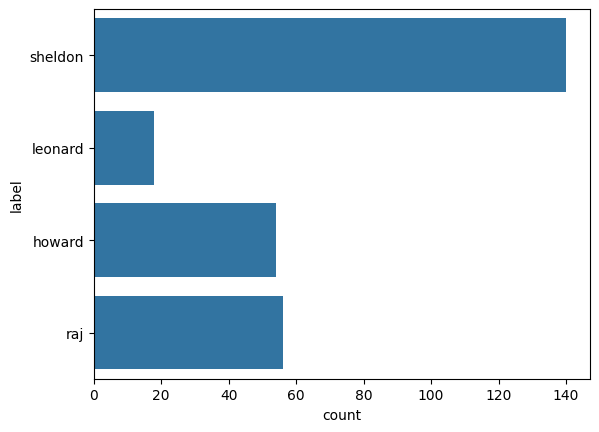

In [26]:
sns.countplot(train['label'])

In [27]:
# Converter para dataframe
test = pd.DataFrame()
test['image'], test['label'] = load_images(test_dir)
# Embaralhar o datase
test = test.sample(frac=1).reset_index(drop=True)
test.head()

raj loaded
sheldon loaded
leonard loaded
howard loaded


,image,label
0,/content/drive/MyDrive/actors_bbt_split/test/s...,sheldon
1,/content/drive/MyDrive/actors_bbt_split/test/s...,sheldon
2,/content/drive/MyDrive/actors_bbt_split/test/s...,sheldon
3,/content/drive/MyDrive/actors_bbt_split/test/r...,raj
4,/content/drive/MyDrive/actors_bbt_split/test/h...,howard


<Axes: xlabel='count', ylabel='label'>

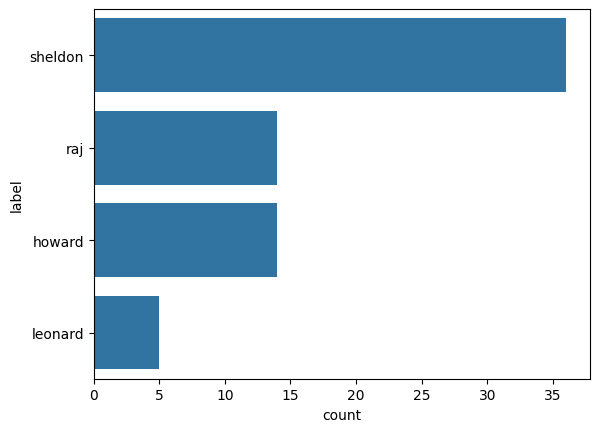

In [29]:
sns.countplot(test['label'])

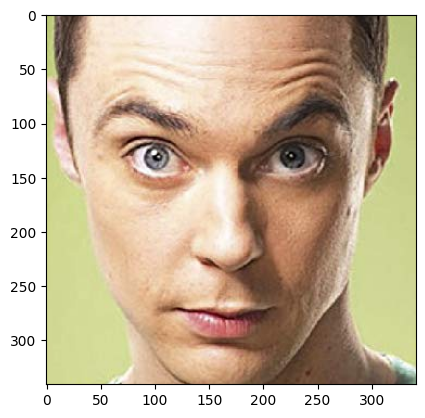

In [32]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img)

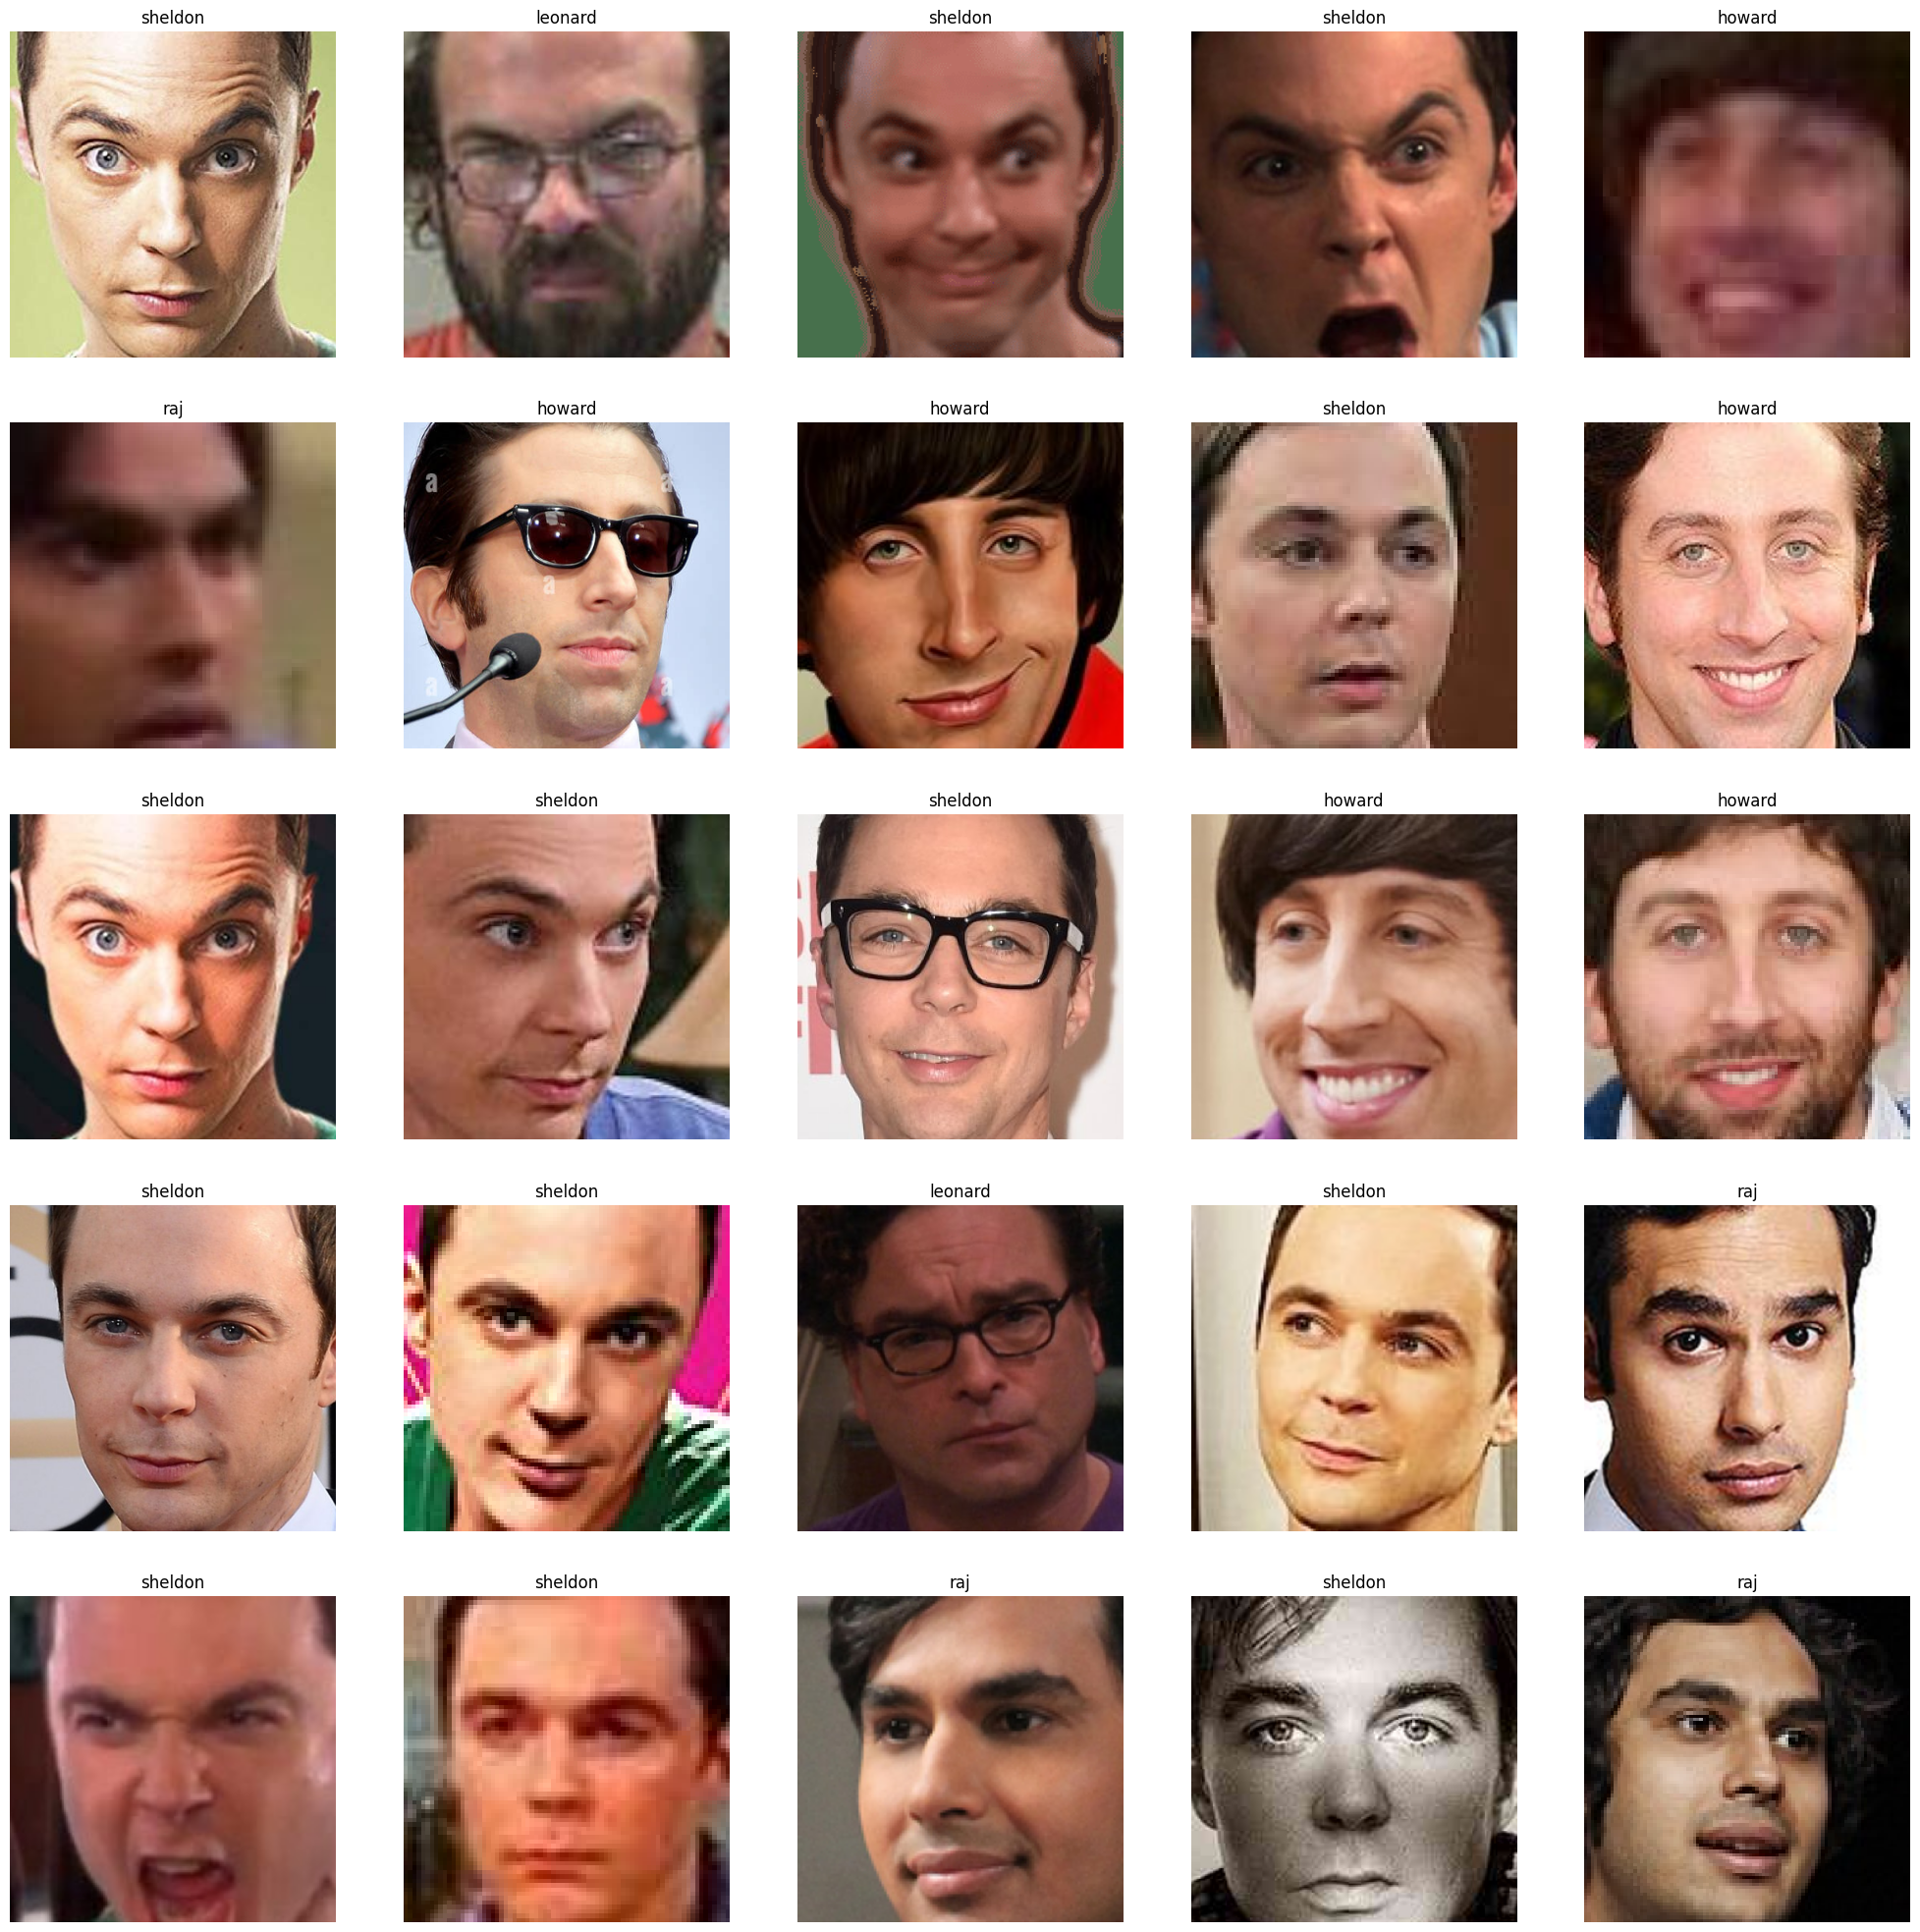

In [33]:
# Display as imagens do datase em grid
plt.figure(figsize=(25, 25))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index + 1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

extract_actors(images) function aims to load images, convert them into a numerical format suitable for machine learning, and then store them in a specific shape.

**Initialization:**

def extract_actors(images): : This line defines a function called extract_actors which takes a list of image paths (images) as input.
actors = []: An empty list called actors is created to store the processed images.
Image Loading and Processing:

for image in tqdm(images):: This loop iterates through each image path in the images list using tqdm which provides a progress bar.
img = cv2.imread(image): This line likely attempts to read the image using OpenCV (cv2), but is immediately overwritten by the next line.
img = Image.open(image): This line opens the image using the PIL (Pillow) library.
img = np.array(img): The image is converted into a NumPy array, essentially transforming it into a matrix of pixel values.
actors.append(img): The NumPy array representation of the image is added to the actors list.
Array Reshaping:

actors = np.array(actors): The actors list, now containing all the image arrays, is converted into a NumPy array itself.
actors = actors.reshape(len(actors), 48, 48, 1): This is a crucial step for deep learning. It reshapes the actors array to have dimensions suitable for a Convolutional Neural Network (CNN).
len(actors): Represents the number of images.
48, 48: Specifies that each image should be resized to 48x48 pixels, a common size in image recognition.
1: Indicates that the images are grayscale (single color channel). If the images were RGB, this value would be 3.
Returning the Result:

return actors: The function returns the final actors array containing the processed and reshaped image data.
In summary: The extract_actors function takes a list of image paths, loads each image, converts them to NumPy arrays, and reshapes them into a format suitable for use in a CNN, typically for image recognition or classification tasks.

In [45]:
def extract_actors(images):
  actors = []
  for image in tqdm(images):
    img = load_img(image, target_size=(48,48), color_mode='rgb')
    img = np.array(img)
    actors.append(img)

  actors = np.array(actors)

  return actors

In [46]:
train_actors = extract_actors(train['image'])

  0%|          | 0/268 [00:00<?, ?it/s]

In [47]:
test_actors = extract_actors(test['image'])

  0%|          | 0/69 [00:00<?, ?it/s]

# Normalização das imagens

In [48]:
x_train = train_actors/255.0
x_test = test_actors/255.0

# Converter as imagens para inteiro

In [49]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [ ]:
input_shape = (48, 48, 3)
num_classes = 4

In [51]:
print("Shape x_train:", x_train.shape)
print("Shape y_train:", y_train.shape)

print("Shape x_test:", x_test.shape)
print("Shape y_test:", y_test.shape)

Shape x_train: (268, 48, 48, 3)
Shape y_train: (268,)
Shape x_test: (69, 48, 48, 3)
Shape y_test: (69,)


## Configuração em categorias

In [53]:
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [54]:
print("Shape x_train:", x_train.shape)
print("Shape y_train:", y_train.shape)

print("Shape x_test:", x_test.shape)
print("Shape y_test:", y_test.shape)

Shape x_train: (268, 48, 48, 3)
Shape y_train: (268, 4)
Shape x_test: (69, 48, 48, 3)
Shape y_test: (69, 4)


In [55]:
y_train[0]

array([0., 0., 0., 1.])

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

In [ ]:
!pip install Augmentor

In [ ]:
for class_name in ['/content/drive/MyDrive/actors_bbt_split/train/leonard', '/content/drive/MyDrive/actors_bbt_split/train/howard', '/content/drive/MyDrive/actors_bbt_split/train/raj']:  # Classes minoritárias
    p = Augmentor.Pipeline(f"/content/drive/MyDrive/actors_bbt_split/train/{class_name}")
    p.rotate(probability=0.7, max_left_rotation=25, max_right_rotation=25)
    p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
    p.sample(1000)  # Gera novas imagens

In [ ]:
# Converte one-hot para índices inteiros (ex: [0, 2, 1, 3])
y_train_indices = np.argmax(y_train, axis=1)  # Chave aqui!

# Calcula os pesos
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_indices),  # Classes únicas (ex: [0, 1, 2, 3])
    y=y_train_indices                    # Labels como inteiros
)
class_weights = dict(enumerate(class_weights))

# Use no model.fit()
# model.fit(..., class_weight=class_weights)

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Treino
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=16),
    epochs=100,
    validation_data=(x_test, y_test),
    callbacks=[early_stop, checkpoint],
    class_weight=class_weights
)